# Project: Train Balancing a pendulum


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np
import csv
import gym
import util
from agents.agent import DDPG

import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Pendulum-v0')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Generate some samples from the state space 
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(5)]))

State space: Box(3,)
- low: [-1. -1. -8.]
- high: [1. 1. 8.]
State space samples:
[[ 0.09762701  0.43037874  1.644214  ]
 [ 0.08976637 -0.1526904   2.3343058 ]
 [-0.12482557  0.78354603  7.4186044 ]
 [-0.23311697  0.5834501   0.46231872]
 [ 0.13608912  0.85119325 -6.863423  ]]


In [3]:
# Explore the action space
print("Action space:", env.action_space)

# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(5)]))

Action space: Box(1,)
Action space samples:
[[-1.6514828]
 [-1.9191264]
 [ 1.3304794]
 [ 1.112627 ]
 [ 1.4800485]]


## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [8]:
# This is nice if you interupt the learning while rendering.
# This will automatically close the previous session.
try:
    agent.task.close()
except:
    pass

num_episodes = 1000

agent = DDPG(env, gym=True)


# general configuration
display_graph = True
display_freq = 1
file_output = 'data.txt'                         # file name for saved results

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']

total_rewards = []

for i_episode in range(1, num_episodes+1):
    
    results = {x : [] for x in labels}
    # Run the simulation, and save the results.
    with open(file_output, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(labels)

        state = agent.reset_episode() # start a new episode
    
        while True:
            action = agent.act(state) 
            next_state, reward, done, _ = env.step(action)
            #print(next_state, reward, done, _)
            #print(done)
            agent.step(action, reward, next_state, done)
            state = next_state
                
            # within the episode loop
            if (i_episode % display_freq == 1):
                to_write = [task.sim.time]
                to_write += list(task.sim.pose)
                to_write += list(task.sim.v)
                to_write += list(task.sim.angular_v)
                to_write += list(action)   #rotor_speeds
                to_write += [reward]                
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
        
            if done:
                # at the end of the episode, add the latest data points to the graph
                #print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                #    i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
                print("\rEpisode = {:4d}".format(i_episode), end="")  # [debug]                                  
                if (i_episode % display_freq == 1):    
                    util.plot_run(results)
                    print('__________________________________________________________________________________________')
                total_rewards.append(reward.sum())   #append(reward.sum())
                break
        sys.stdout.flush()

Episode =  437

KeyboardInterrupt: 

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

ValueError: x and y must have same first dimension, but have shapes (1000,) and (437,)

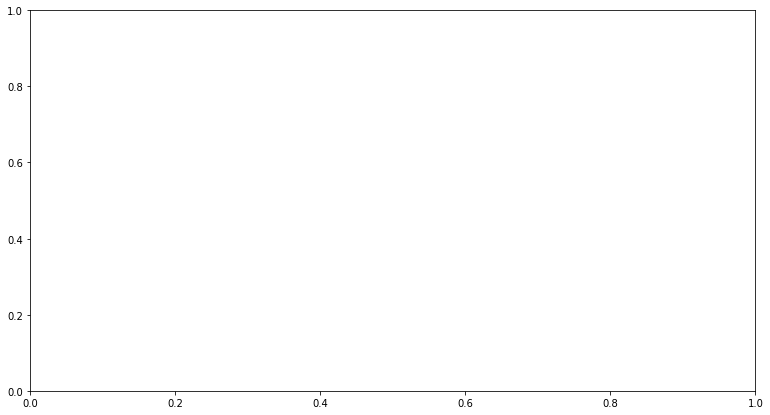

In [9]:
#plot episode rewards
plt.figure(figsize=(13,7))
plt.plot(range(1, num_episodes + 1), total_rewards, label='episode total rewards')
plt.legend()
plt.show()


In [ ]:
util.plot_run(results)

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: 
In `task.py` the task class is loaded. It initializes the PhysicsSim model, action repeats, and sets the interface to the cuadcopter parameters. It also sets up the reward function. 

I took the reward function 
* reward = 1. - .3 * (abs(self.sim.pose[:3] - self.target_pos)).sum()*

It calculates the difference between target- and actual position. The bigger the difference, the lower the reward. I thought about taking the squared difference, but as it does not seem to be good in general to have big values for rewards, I did not try that in the end.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**: I took the DDPG algorithm (**Continuous Control with Deep Reinforcement Learning**). This is a model-free algorithm based on deterministic policy gradient which is especially suited to operate over continuous action spaces. (DDPG = Deep Deterministic Policy Gradient)

* Hyperparameters:
I tried to choose most of the parameters as indicated in the *Experiment Details* section in the DDPG paper. The discount rate for the rewards was set to $\gamma = 0.99$ and the learning rate for the soft target updates is set to $\tau = 0,001$ The actor-NN final output layer activation function was set to $\tanh$. 

I used 2 hidden layers of the 

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: